# Attacking simple classifier

This example shows the use of Minimal MIA Toolkit through attacking a simple convolutional network trained on CIFAR-10 dataset. The example is inspired by [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#training-a-classifier) post from PyTorch. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tempfile

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from mmiat.utils.partitioningutils import torch_iid_partitioning
from mmiat.utils.deviceutils import optimal_device

from mmiat.utils.data import AttackPredictionDataset
from mmiat.attacks import LossAttack
from mmiat.evaluation.aggregate_metrics import calculate_miametrics
from mmiat.evaluation.reporting.plot import create_mia_metric_report, show_various_mia_attack_comparison

### Data loading

In [3]:
batch_size = 4
device = optimal_device()

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

with tempfile.TemporaryDirectory() as tempdir:
    cifartrainsplit = torchvision.datasets.CIFAR10(root=tempdir, train=True,
                                            download=True, transform=transform)
    trainset, attackset = torch_iid_partitioning(cifartrainsplit, 0.5)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                                shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root=tempdir, train=False,
                                            download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                                shuffle=False, num_workers=2)   

    attackprediction_dataset = AttackPredictionDataset(trainset, attackset)

100%|██████████| 170M/170M [00:51<00:00, 3.31MB/s] 


### Model initialization

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training the model and attacking it

In [7]:
lossattack = LossAttack(
    device=device, 
    batch_size=batch_size, 
    # reduction = 'none' makes it so we get loss for each sample, otherwise only a scalar is returned
    criterion=nn.CrossEntropyLoss(reduction='none') 
)

metrics_over_rounds = []

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
    if (epoch + 1) % 2 == 0:
        # Attack the model after every 2 epochs
        membership_labels, confidences = lossattack.attack(net, attackprediction_dataset)
        metrics_over_rounds.append(
            calculate_miametrics(membership_labels, confidences))

print('Finished Training')

[1,  2000] loss: 2.141
[1,  4000] loss: 1.835
[1,  6000] loss: 1.676
[2,  2000] loss: 1.553
[2,  4000] loss: 1.513
[2,  6000] loss: 1.487


Loss Attack: 100%|██████████| 12500/12500 [00:18<00:00, 671.58it/s]


[3,  2000] loss: 1.399
[3,  4000] loss: 1.387
[3,  6000] loss: 1.367
[4,  2000] loss: 1.282
[4,  4000] loss: 1.287
[4,  6000] loss: 1.273


Loss Attack: 100%|██████████| 12500/12500 [00:17<00:00, 731.28it/s]


[5,  2000] loss: 1.183
[5,  4000] loss: 1.201
[5,  6000] loss: 1.177
[6,  2000] loss: 1.100
[6,  4000] loss: 1.129
[6,  6000] loss: 1.126


Loss Attack: 100%|██████████| 12500/12500 [00:16<00:00, 752.67it/s]


[7,  2000] loss: 1.040
[7,  4000] loss: 1.069
[7,  6000] loss: 1.056
[8,  2000] loss: 0.976
[8,  4000] loss: 1.003
[8,  6000] loss: 1.013


Loss Attack: 100%|██████████| 12500/12500 [00:19<00:00, 650.70it/s]


[9,  2000] loss: 0.911
[9,  4000] loss: 0.943
[9,  6000] loss: 0.965
[10,  2000] loss: 0.849
[10,  4000] loss: 0.921
[10,  6000] loss: 0.930


Loss Attack: 100%|██████████| 12500/12500 [00:16<00:00, 735.77it/s]

Finished Training


### Showing the results

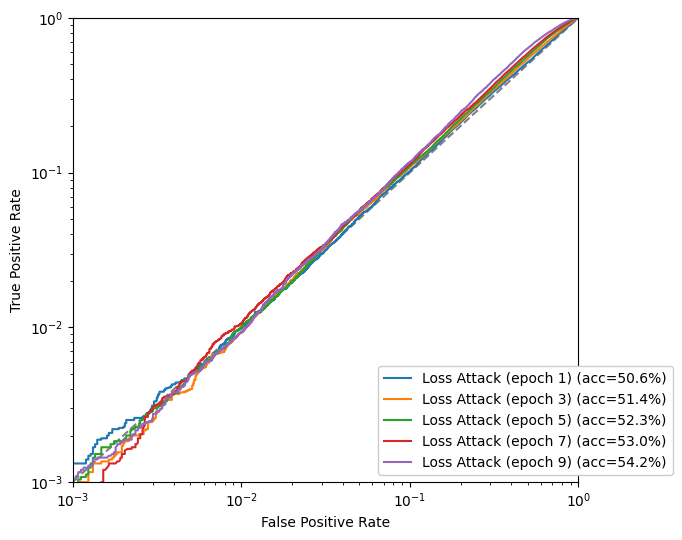

In [8]:
show_various_mia_attack_comparison({
    f"Loss Attack (epoch {i * 2 + 1})": metrics
    for i, metrics in enumerate(metrics_over_rounds)
}, ["accuracy", "loglog"])

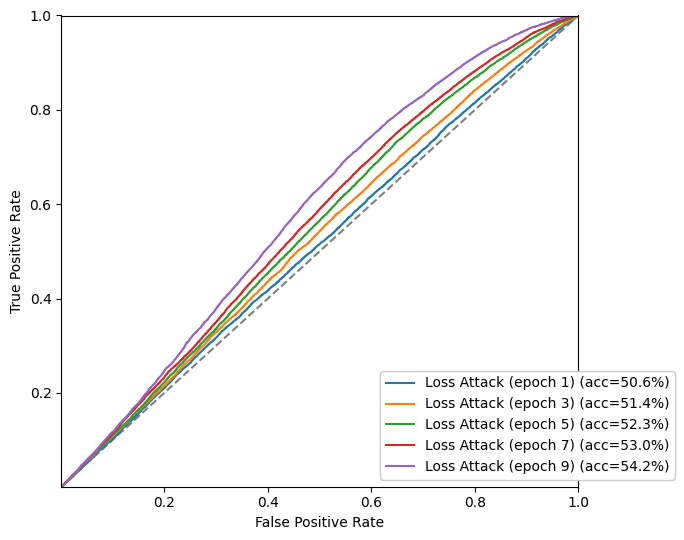

In [9]:
show_various_mia_attack_comparison({
    f"Loss Attack (epoch {i * 2 + 1})": metrics
    for i, metrics in enumerate(metrics_over_rounds)
}, ["accuracy"])

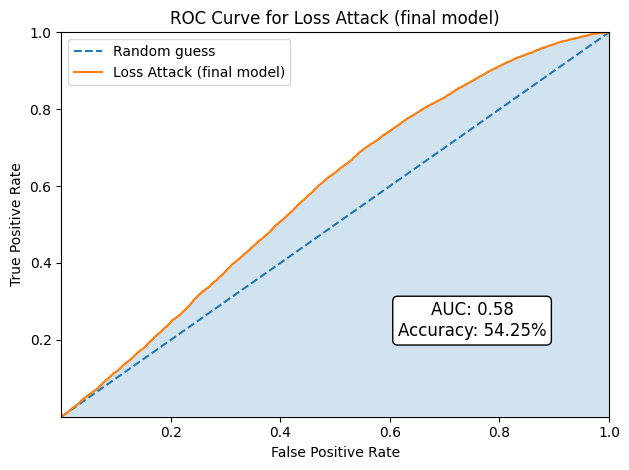

In [11]:
create_mia_metric_report(
    metrics_over_rounds[-1],
    "Loss Attack (final model)",
    ["accuracy", "auc"]
)